## 08 — Model Evaluation & Explainability
Evaluate the tuned TF‑IDF + Logistic‑Regression pipeline on the held‑out
test set, generate diagnostic figures, and persist artefacts needed by
downstream notebooks / dashboards.

## 1 — Imports & deterministic backend

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"   # crisper plots on Hi‑DPI

# %% 1 — Imports & deterministic backend
from __future__ import annotations

import json
import joblib
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    RocCurveDisplay,
)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore", category=UserWarning)

SEED              = 42
np.random.seed(SEED)

# project paths --------------------------------------------------------------
ROOT_DIR     = Path.cwd().resolve().parents[0]               # notebooks/ → repo root
DATA_DIR     = ROOT_DIR / "data" / "processed"
MODELS_DIR   = ROOT_DIR / "models"
REPORTS_DIR  = ROOT_DIR / "reports"
FIGS_DIR     = REPORTS_DIR / "figs_eval"
FIGS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_JSON = REPORTS_DIR / "metrics_model_v1.json"


## 2 — Load artefacts (model & test split)

In [3]:
pipe_lr = joblib.load(MODELS_DIR / "logreg_tfidf.joblib")     # tuned model

X_test   = pd.read_feather(DATA_DIR / "X_test.ftr")["text"].to_numpy()
y_test   = pd.read_feather(DATA_DIR / "y_test.ftr")["label"].to_numpy()
classes  = pipe_lr.classes_

y_pred   = pipe_lr.predict(X_test)
y_proba  = pipe_lr.predict_proba(X_test)

print(f"Test shape: {X_test.shape},  classes: {list(classes)}")

Test shape: (1464,),  classes: ['negative', 'neutral', 'positive']


## 3 — Classification report & confusion matrix

              precision    recall  f1-score   support

    negative      0.892     0.841     0.866       918
     neutral      0.609     0.719     0.660       310
    positive      0.695     0.686     0.691       236

    accuracy                          0.790      1464
   macro avg      0.732     0.749     0.739      1464
weighted avg      0.801     0.790     0.794      1464



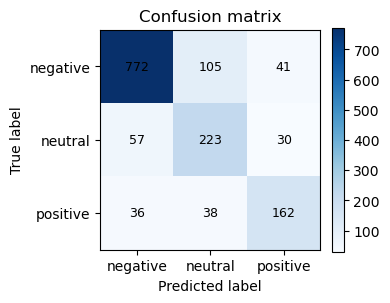

In [10]:
print(classification_report(y_test, y_pred, digits=3))

cm   = confusion_matrix(y_test, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(classes)), classes)
ax.set_yticks(range(len(classes)), classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
fig.colorbar(im, ax=ax, fraction=0.046)
ax.set_title("Confusion matrix")
fig.tight_layout()
fig.savefig(FIGS_DIR / "confusion_matrix.png", dpi=150)
plt.show() 
plt.close(fig)

## 4 — ROC (one‑vs‑rest, micro & macro AUC)

c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\justi\Anaconda3\envs\twitter-sentiment-env\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


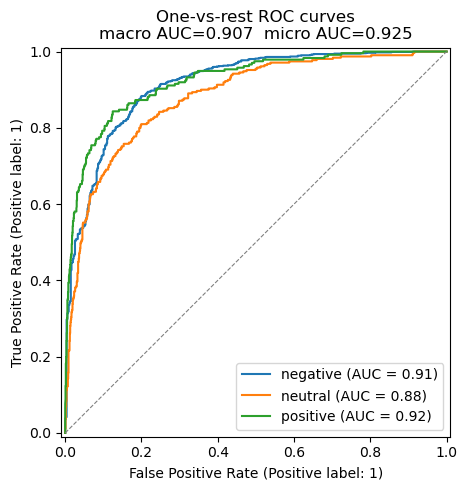

In [11]:
y_bin  = label_binarize(y_test, classes=classes)
fig, ax = plt.subplots(figsize=(5, 5))

macro_auc = roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")
micro_auc = roc_auc_score(y_bin, y_proba, average="micro", multi_class="ovr")

for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_true=y_bin[:, i],
        y_pred=y_proba[:, i],
        name=cls,
        ax=ax,
    )

ax.plot([0, 1], [0, 1], ls="--", color="grey", lw=0.8)
ax.set_title(
    f"One‑vs‑rest ROC curves\nmacro AUC={macro_auc:.3f}  micro AUC={micro_auc:.3f}"
)
fig.tight_layout()
fig.savefig(FIGS_DIR / "roc_ovr.png", dpi=150)
plt.show() 
plt.close(fig)

## 5 — Top tokens driving each class (log‑reg coefficients)